# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

# Ход исследования

Шаг 1. Загрузка данных

Шаг 2. Исследовательский анализ и предобработка данных

Шаг 3. Объединение данных

Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Шаг 5. Подготовка данных

Шаг 6. Обучение моделей машинного обучения

Шаг 7. Выбор лучшей модели

Шаг 8. Общий вывод и рекомендации заказчику

## Загрузка данных

In [1]:
! pip install phik -q
! pip install -Uq scikit-learn

Загружаем библиотеки 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyRegressor


Скачиваем датасеты

In [3]:
data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

Сделаем первичный осмотр

In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [6]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [7]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [8]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [9]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Вывод: Мы загрузили данные и выполнили их первичный осмотр

## Исследовательский анализ и предобработка данных

### Проверим правильность типов данных и соблюдения змеиного стиля для каждого столбца

In [11]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [12]:
data_arc.key.value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

In [13]:
data_arc.columns = ['key', 'start', 'end', 'active', 'reactive']
data_arc['start'] = pd.to_datetime(data_arc['start'])
data_arc['end'] = pd.to_datetime(data_arc['end'])

In [14]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [16]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [17]:
data_bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_bulk_time.loc[:, ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']] = data_bulk_time.loc[:, ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']].apply(pd.to_datetime)

In [18]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [19]:
data_gas.columns = ['key', 'gas_1']

In [20]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [21]:
data_temp.columns = ['key', 'time', 'temp']
data_temp['time'] = pd.to_datetime(data_temp['time'])

In [22]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [23]:
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [24]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [25]:
data_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire_time.loc[:, ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']] = data_wire_time.loc[:, ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']].apply(pd.to_datetime)

### Обработка пропусков

In [26]:
def check_missing_values(df):
    for column in df.columns:
        missing_values_count = df[column].isnull().sum()
        print(f"Столбец '{column}': {missing_values_count} пропусков")

In [27]:
check_missing_values(data_arc)

Столбец 'key': 0 пропусков
Столбец 'start': 0 пропусков
Столбец 'end': 0 пропусков
Столбец 'active': 0 пропусков
Столбец 'reactive': 0 пропусков


In [28]:
check_missing_values(data_bulk)

Столбец 'key': 0 пропусков
Столбец 'bulk_1': 2877 пропусков
Столбец 'bulk_2': 3107 пропусков
Столбец 'bulk_3': 1831 пропусков
Столбец 'bulk_4': 2115 пропусков
Столбец 'bulk_5': 3052 пропусков
Столбец 'bulk_6': 2553 пропусков
Столбец 'bulk_7': 3104 пропусков
Столбец 'bulk_8': 3128 пропусков
Столбец 'bulk_9': 3110 пропусков
Столбец 'bulk_10': 2953 пропусков
Столбец 'bulk_11': 2952 пропусков
Столбец 'bulk_12': 679 пропусков
Столбец 'bulk_13': 3111 пропусков
Столбец 'bulk_14': 323 пропусков
Столбец 'bulk_15': 881 пропусков


In [29]:
data_bulk = data_bulk.fillna(0)

In [30]:
check_missing_values(data_gas)

Столбец 'key': 0 пропусков
Столбец 'gas_1': 0 пропусков


In [31]:
check_missing_values(data_temp)

Столбец 'key': 0 пропусков
Столбец 'time': 0 пропусков
Столбец 'temp': 3427 пропусков


Удалим пропуски в data_temp

In [32]:
data_temp = data_temp.dropna(subset=['temp'])

In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     14665 non-null  int64         
 1   time    14665 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB


In [34]:
check_missing_values(data_wire)

Столбец 'key': 0 пропусков
Столбец 'wire_1': 26 пропусков
Столбец 'wire_2': 2002 пропусков
Столбец 'wire_3': 3018 пропусков
Столбец 'wire_4': 3067 пропусков
Столбец 'wire_5': 3080 пропусков
Столбец 'wire_6': 3008 пропусков
Столбец 'wire_7': 3070 пропусков
Столбец 'wire_8': 3062 пропусков
Столбец 'wire_9': 3052 пропусков


In [35]:
data_wire = data_wire.fillna(0)

### Проврека явных дубликатов

In [36]:
data_arc.duplicated().any()

False

In [37]:
data_bulk.duplicated().any()

False

In [38]:
data_bulk_time.duplicated().any()

False

In [39]:
data_gas.duplicated().any()

False

In [40]:
data_temp.duplicated().any()

False

In [41]:
data_wire.duplicated().any()

False

In [42]:
data_wire.duplicated().any()

False

Вывод:
    
Провели загрузку данных. Имена столбцов достаточно информативны и их не переименовывали.

Обнаружили пропуски в данных, что свидетельствует об отсутсвии использования в технологическом процессе данного материала и в дальнейшем целесообразно заполнить значение на "0".

### Исследовательский анализ данных

In [43]:
def visualize_dataframe(dataframe):
    for column in dataframe.columns:
        column_type = dataframe[column].dtype

        if column_type == 'object':
            value_counts = dataframe[column].value_counts()
            value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
            plt.title(f'{column} - Круговая диаграмма')
            plt.show()

        elif column_type in ['int64', 'float64'] and column != 'id':
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
            dataframe[column].plot.hist(bins=25, ax=axes[0])
            axes[0].set_title(f'{column} - Гистограмма')
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Частота')
            sns.boxplot(x=dataframe[column], ax=axes[1])
            axes[1].set_title(f'{column} - Boxplot')
            axes[1].set_xlabel(column)

            plt.show()
            
            print(dataframe[column].describe())

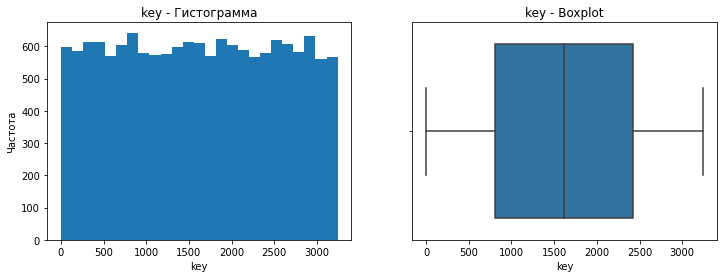

count    14876.000000
mean      1615.220422
std        934.571502
min          1.000000
25%        806.000000
50%       1617.000000
75%       2429.000000
max       3241.000000
Name: key, dtype: float64


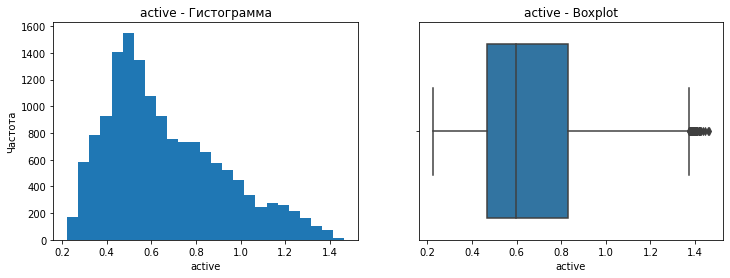

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active, dtype: float64


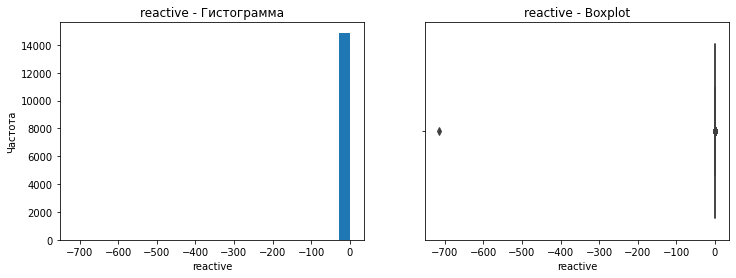

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive, dtype: float64


In [44]:
visualize_dataframe(data_arc)

На гистограмме видна аномалия. Надо её обработать

In [45]:
display(data_arc.loc[data_arc['reactive'] < 0].style.background_gradient(cmap='Blues', axis=0).hide_index())

key,start,end,active,reactive
2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [46]:
data_arc = data_arc.loc[data_arc['key'] != 2116]

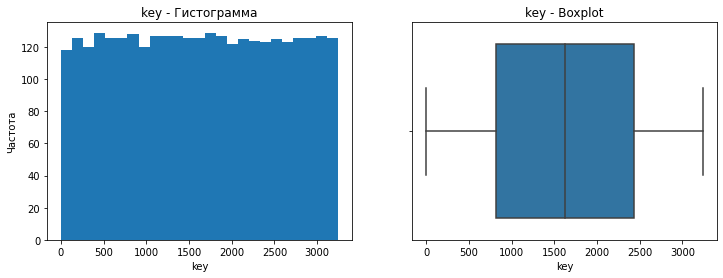

count    3129.000000
mean     1624.383509
std       933.337642
min         1.000000
25%       816.000000
50%      1622.000000
75%      2431.000000
max      3241.000000
Name: key, dtype: float64


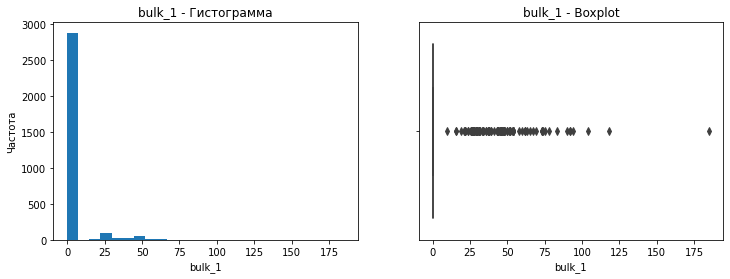

count    3129.000000
mean        3.160435
std        11.869164
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64


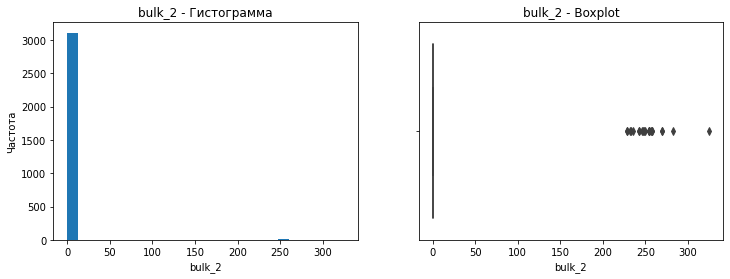

count    3129.000000
mean        1.779163
std        21.217878
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64


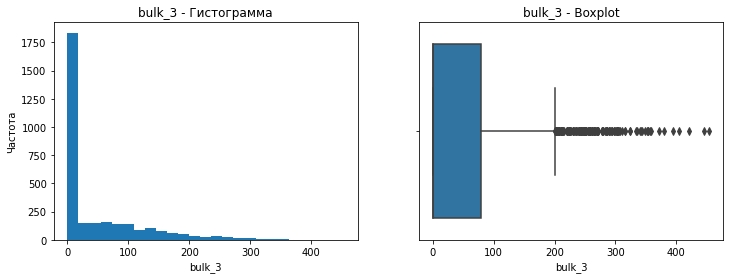

count    3129.000000
mean       47.240332
std        74.239954
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64


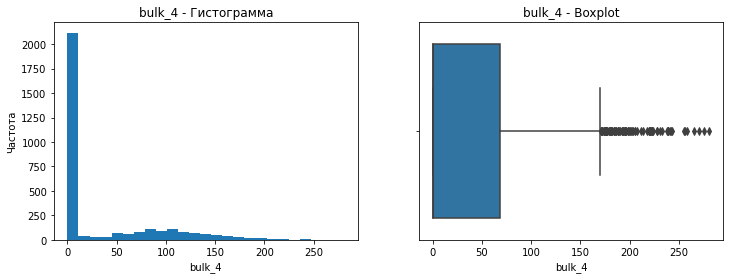

count    3129.000000
mean       33.830617
std        56.034505
min         0.000000
25%         0.000000
50%         0.000000
75%        68.000000
max       281.000000
Name: bulk_4, dtype: float64


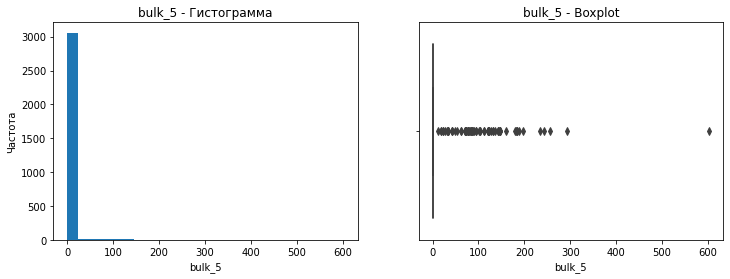

count    3129.000000
mean        2.633749
std        20.918138
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64


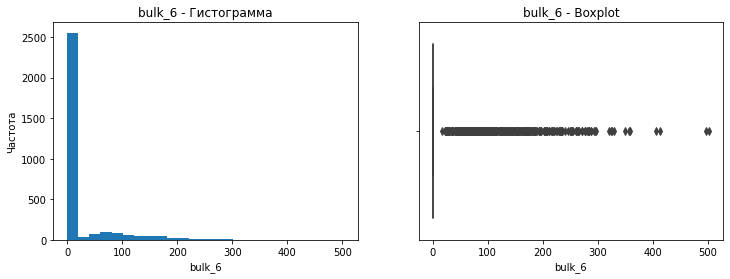

count    3129.000000
mean       21.892298
std        55.492582
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64


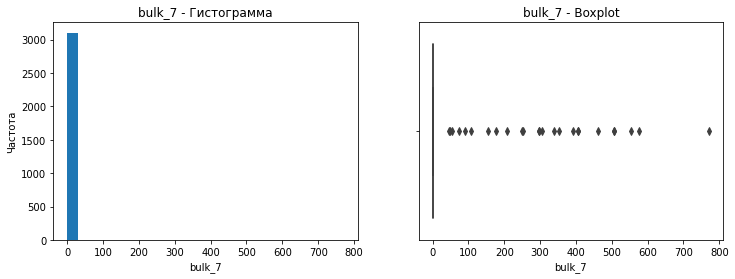

count    3129.000000
mean        2.441675
std        31.944063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64


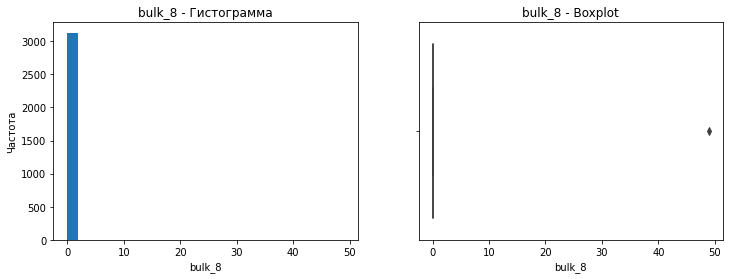

count    3129.000000
mean        0.015660
std         0.875978
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: bulk_8, dtype: float64


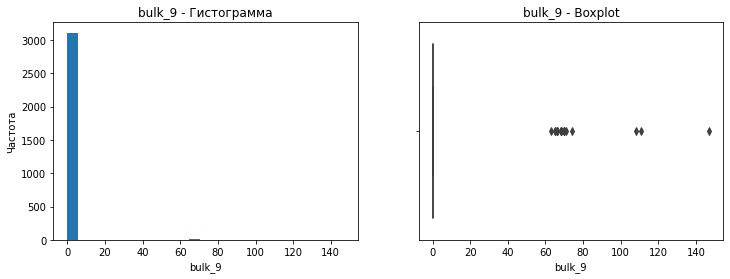

count    3129.000000
mean        0.463407
std         6.154398
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: bulk_9, dtype: float64


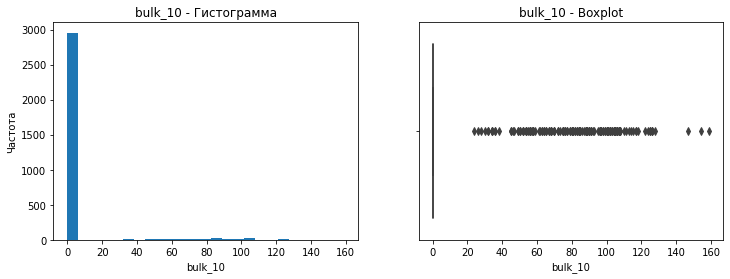

count    3129.000000
mean        4.684564
std        20.157323
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64


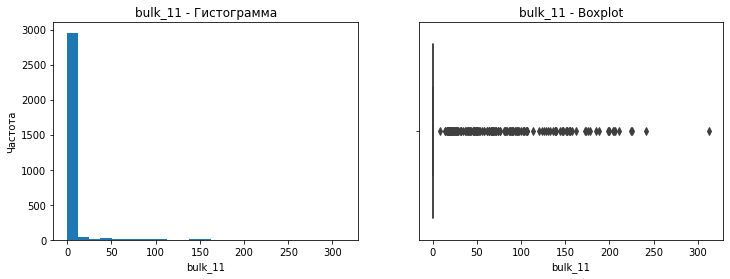

count    3129.000000
mean        4.345478
std        22.699580
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64


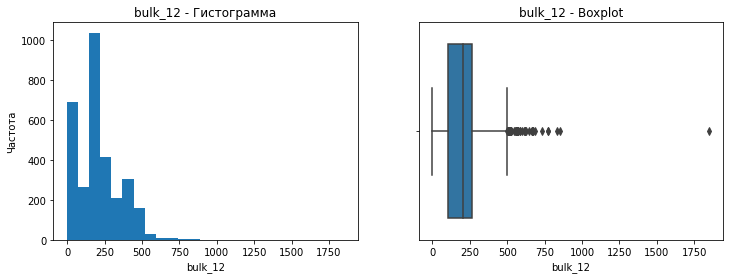

count    3129.000000
mean      203.948226
std       151.419639
min         0.000000
25%       105.000000
50%       206.000000
75%       263.000000
max      1849.000000
Name: bulk_12, dtype: float64


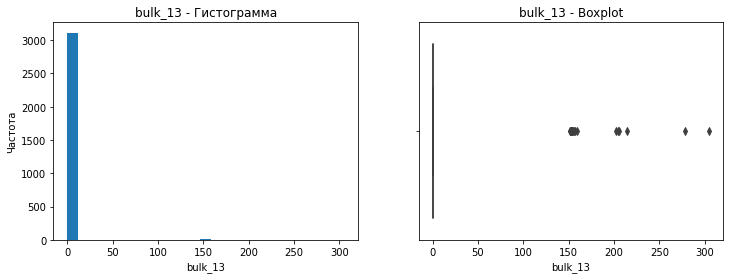

count    3129.000000
mean        1.041866
std        14.114252
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: bulk_13, dtype: float64


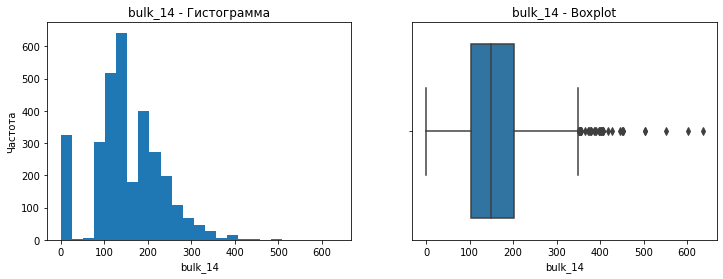

count    3129.000000
mean      152.706616
std        81.091421
min         0.000000
25%       104.000000
50%       148.000000
75%       202.000000
max       636.000000
Name: bulk_14, dtype: float64


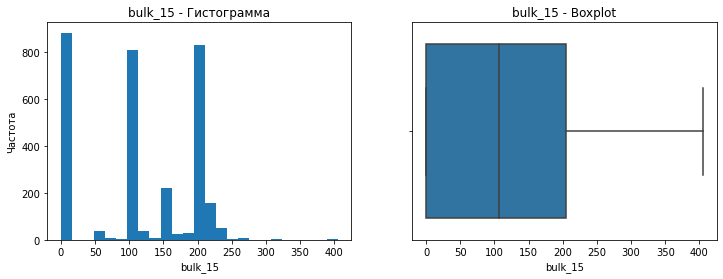

count    3129.000000
mean      115.319271
std        84.488698
min         0.000000
25%         0.000000
50%       106.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64


In [47]:
visualize_dataframe(data_bulk)

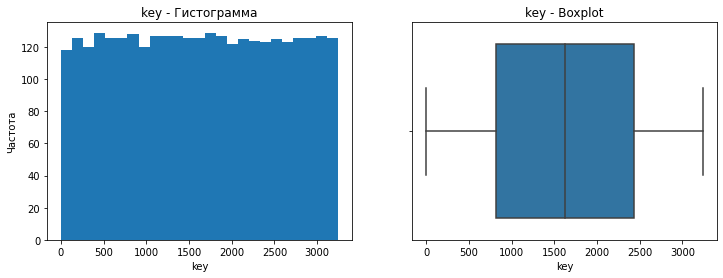

count    3129.000000
mean     1624.383509
std       933.337642
min         1.000000
25%       816.000000
50%      1622.000000
75%      2431.000000
max      3241.000000
Name: key, dtype: float64


In [48]:
visualize_dataframe(data_bulk_time)

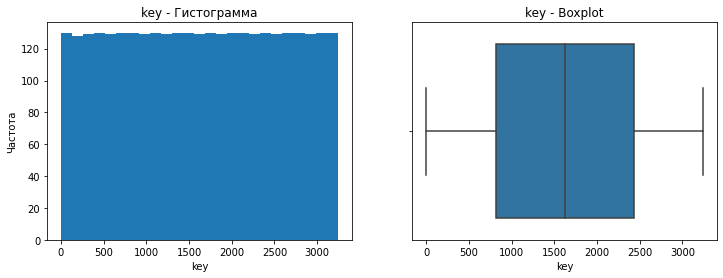

count    3239.000000
mean     1621.861377
std       935.386334
min         1.000000
25%       812.500000
50%      1622.000000
75%      2431.500000
max      3241.000000
Name: key, dtype: float64


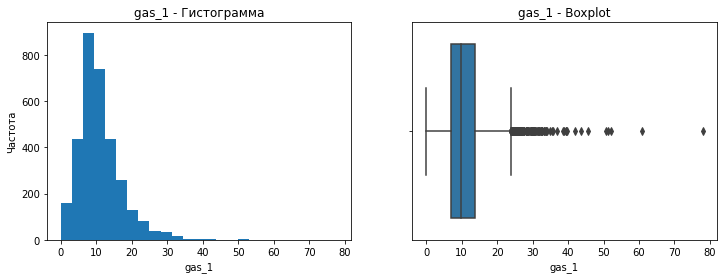

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64


In [49]:
visualize_dataframe(data_gas)

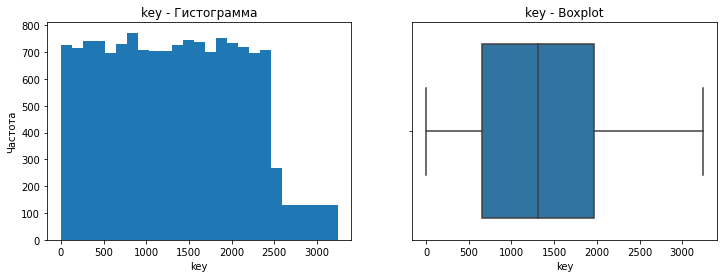

count    14665.000000
mean      1325.484214
std        787.375969
min          1.000000
25%        654.000000
50%       1314.000000
75%       1963.000000
max       3241.000000
Name: key, dtype: float64


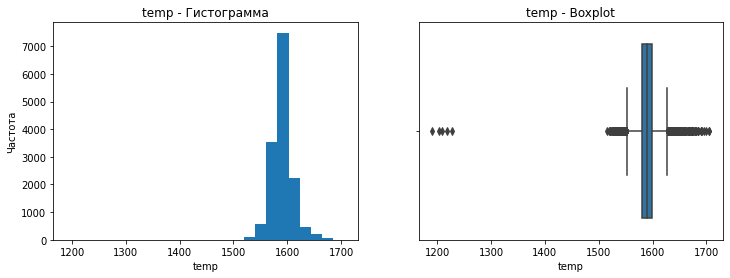

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


In [50]:
visualize_dataframe(data_temp)

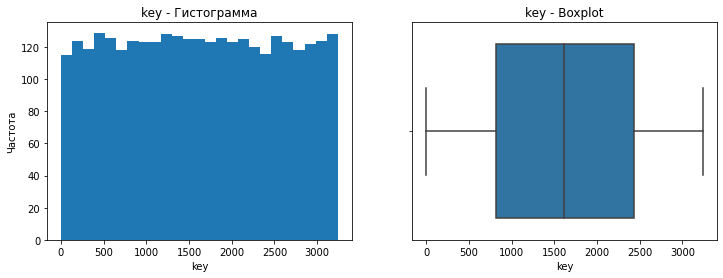

count    3081.000000
mean     1623.426485
std       932.996726
min         1.000000
25%       823.000000
50%      1619.000000
75%      2434.000000
max      3241.000000
Name: key, dtype: float64


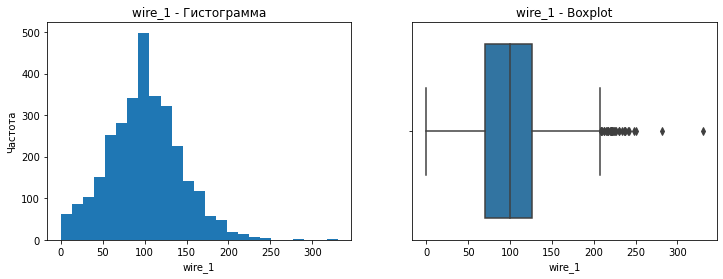

count    3081.000000
mean      100.044411
std        42.841120
min         0.000000
25%        70.281120
50%       100.114563
75%       125.798405
max       330.314424
Name: wire_1, dtype: float64


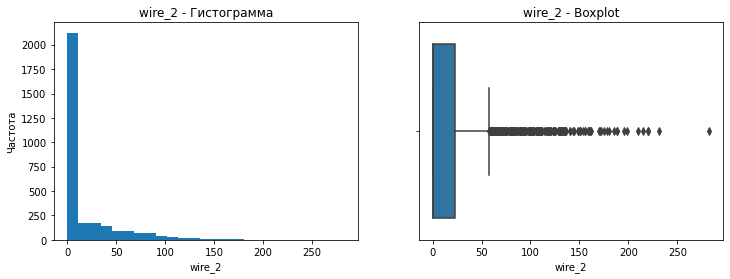

count    3081.000000
mean       17.712733
std        33.517734
min         0.000000
25%         0.000000
50%         0.000000
75%        23.162880
max       282.780152
Name: wire_2, dtype: float64


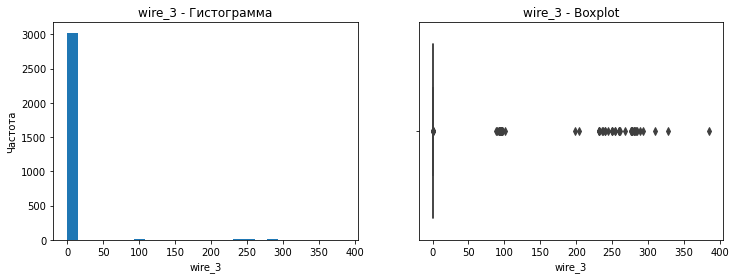

count    3081.000000
mean        3.874524
std        30.310417
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64


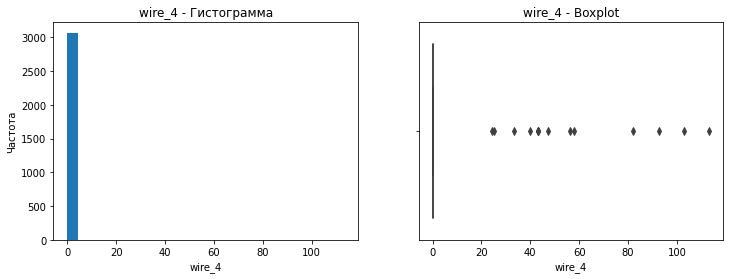

count    3081.000000
mean        0.261019
std         4.293865
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: wire_4, dtype: float64


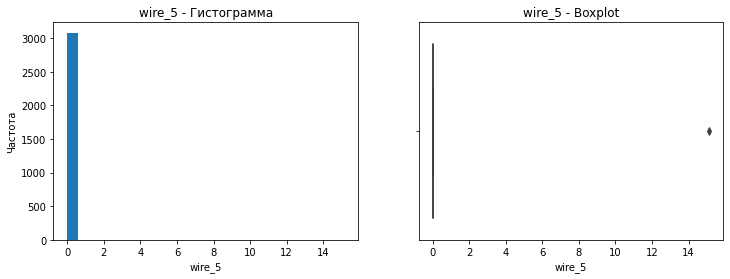

count    3081.000000
mean        0.004911
std         0.272615
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.132000
Name: wire_5, dtype: float64


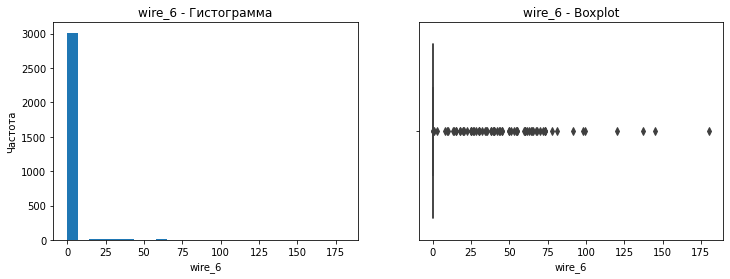

count    3081.000000
mean        1.137695
std         8.958111
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64


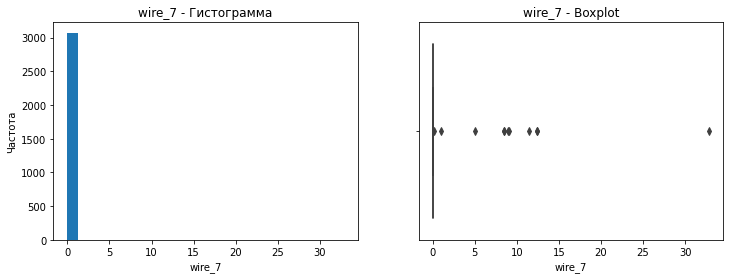

count    3081.000000
mean        0.035842
std         0.774190
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        32.847674
Name: wire_7, dtype: float64


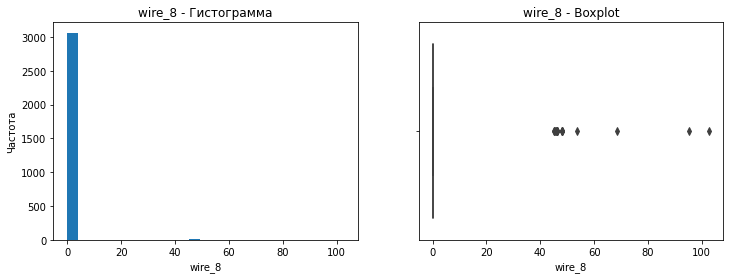

count    3081.000000
mean        0.330697
std         4.392677
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: wire_8, dtype: float64


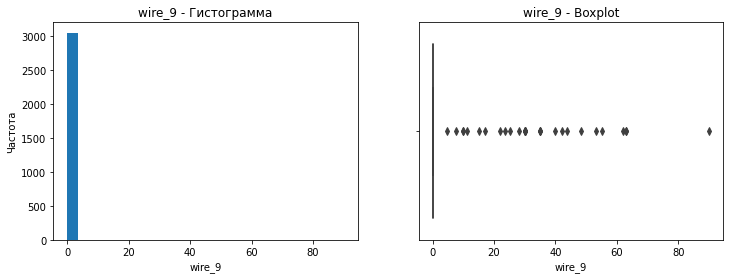

count    3081.000000
mean        0.321492
std         3.806904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        90.053604
Name: wire_9, dtype: float64


In [51]:
visualize_dataframe(data_wire)

Создадим признаки минимальной и окончательной температуры

In [52]:
data_temp['first_temp']=data_temp['temp']
data_temp['last_temp']=data_temp['temp']
data_temp_columns = { 'first_temp' : 'first', 'last_temp' : 'last'}
data_temp['last_temp'] = data_temp['last_temp'].astype(int)
data_temp['first_temp'] = data_temp['first_temp'].astype(int)
data_temp = data_temp.groupby('key').agg(data_temp_columns)
data_temp = data_temp.loc[data_temp['first_temp'] > 1400]

In [53]:
data_temp

,first_temp,last_temp
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602
...,...,...
3237,1569,1569
3238,1584,1584
3239,1598,1598


In [54]:
data_temp = data_temp.loc[data_temp['first_temp'] != data_temp['last_temp']]

In [55]:
data_temp

,first_temp,last_temp
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602
...,...,...
2495,1570,1591
2496,1554,1591
2497,1571,1589


Окончательная температура является целевым признаком по требованию заказчика

Полная мощность равна геометрической сумме векторов активной и реактивной мощностей. Эти вектора перпендикулярны и посчитаем полную мощность по формуле. Посчитаем время затраченное на каждое включение на нагрев и работу (затраты электроэнергии) на каждое включение.

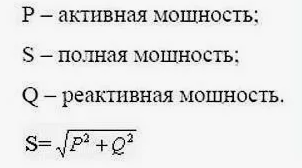

In [56]:
data_arc['full'] = (data_arc['active']**2 + data_arc['reactive']**2)**(0.5)

Работа равняется произведению мощности на время

In [57]:
data_arc['time'] = (data_arc['end'] - data_arc['start']).astype('timedelta64[s]')
data_arc['time'] = data_arc['time'].astype(int)
data_arc['work'] = data_arc['full']*data_arc['time']

Для каждой партии посчитаем среднее значение мощности. Посчитаем затраченную электроэнергию суммировав затраты на каждую партию.

In [58]:
data_arc_columns = {
    'key'            : 'count', 
    'start' : 'min',
    'end' : 'max',
    'active'   : 'mean',
    'reactive' : 'mean',
    'full'    : 'mean',
    'time' : 'sum',
    'work' : 'sum'
}
data_arc = data_arc.groupby('key').agg(data_arc_columns).rename(columns={'key':'Количество циклов нагрева'})

In [59]:
data_arc.drop(['start', 'end'], axis= 1 , inplace= True ) 
data_arc.head(10)

,Количество циклов нагрева,active,reactive,full,time,work
key,,,,,,
1,5,0.607346,0.428564,0.743747,1098,770.282114
2,4,0.534852,0.363339,0.647087,811,481.760005
3,5,0.812728,0.587491,1.003845,655,722.837668
4,4,0.676622,0.514248,0.850010,741,683.455597
5,4,0.563238,0.421998,0.704245,869,512.169934
6,4,0.681318,0.470328,0.828269,952,839.231310
7,4,0.656719,0.490105,0.820978,673,613.576982
8,4,0.669740,0.524238,0.851489,913,619.129542
9,5,0.704164,0.505473,0.867052,625,570.113675


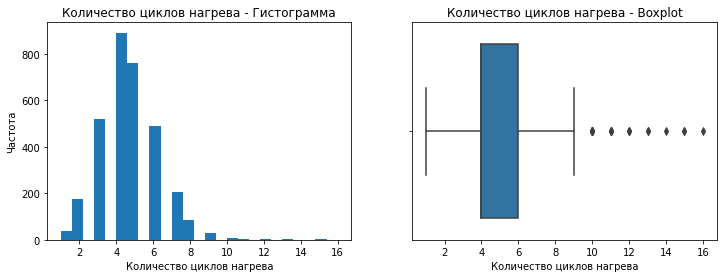

count    3213.000000
mean        4.628696
std         1.608860
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Количество циклов нагрева, dtype: float64


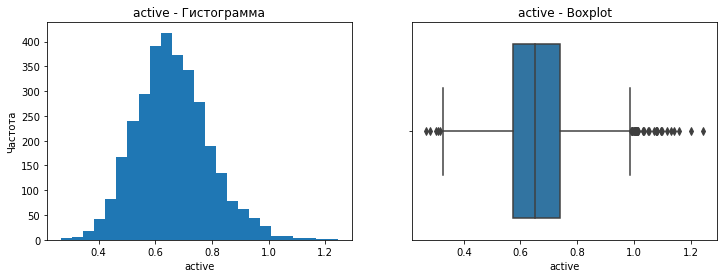

count    3213.000000
mean        0.661332
std         0.128392
min         0.267676
25%         0.573010
50%         0.652864
75%         0.739401
max         1.243889
Name: active, dtype: float64


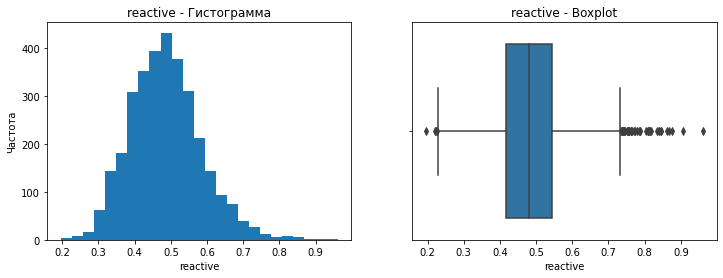

count    3213.000000
mean        0.485966
std         0.097600
min         0.196228
25%         0.417393
50%         0.481626
75%         0.543327
max         0.960763
Name: reactive, dtype: float64


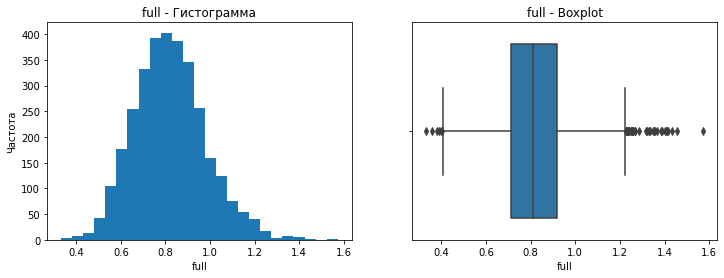

count    3213.000000
mean        0.821565
std         0.160135
min         0.331897
25%         0.711188
50%         0.812374
75%         0.916626
max         1.572238
Name: full, dtype: float64


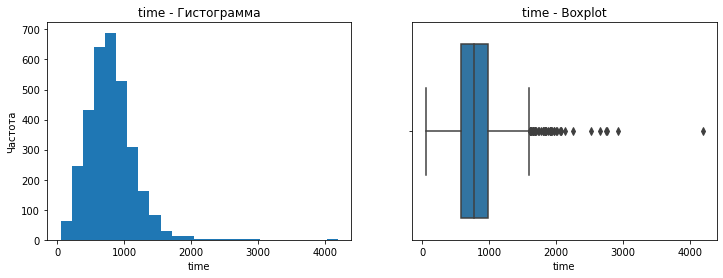

count    3213.000000
mean      794.691566
std       332.439136
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: time, dtype: float64


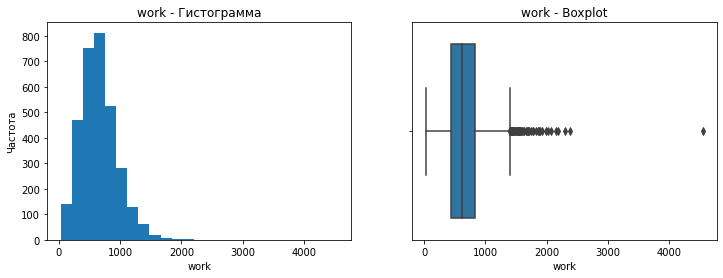

count    3213.000000
mean      655.688884
std       308.950188
min        33.430208
25%       444.864502
50%       620.111140
75%       827.784614
max      4546.405812
Name: work, dtype: float64


In [60]:
visualize_dataframe(data_arc)

Ведем дополнительный признак Bulk sum общего объема добавленного сыпучего материала в расплав.

In [61]:
data_bulk['Bulk_sum'] = data_bulk.sum(axis=1)
data_bulk = data_bulk.astype(int)
display(data_bulk.head(10))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,Bulk_sum
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,554
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,584
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,547
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,599
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,589
5,6,0,0,0,117,0,0,0,0,0,0,0,204,0,201,154,682
6,7,0,0,0,117,0,0,0,0,0,0,0,204,0,152,154,634
7,8,0,0,0,99,0,0,0,0,0,0,0,410,0,252,153,922
8,9,0,0,0,117,0,0,0,0,0,0,0,107,0,99,203,535
9,10,0,0,0,0,0,0,0,0,0,0,0,203,0,102,204,519


Вывод: Выполнен исследовательский анализ и выполнена предобработка каждого датафрейма. Ненужные признаки были удалены. К тому же, было добавлено пару новых признаков 

## Объединение данных

Объединим данные по ключу key

In [62]:
data_names = [data_bulk, data_gas, data_temp, data_wire]
total = data_arc
for data in data_names:
    total = total.merge(data, on=['key'])
display(total.head(10).style.hide_index())

key,Количество циклов нагрева,active,reactive,full,time,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,Bulk_sum,gas_1,first_temp,last_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1,5,0.607346,0.428564,0.743747,1098,770.282114,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,554,29.749986,1571,1613,60.059998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4,0.534852,0.363339,0.647087,811,481.760005,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,584,12.555561,1581,1602,96.052315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5,0.812728,0.587491,1.003845,655,722.837668,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,547,28.554793,1596,1599,91.160157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.676622,0.514248,0.850010,741,683.455597,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,599,18.841219,1601,1625,89.063515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,4,0.563238,0.421998,0.704245,869,512.169934,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,589,5.413692,1576,1602,89.238236,9.114560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,4,0.681318,0.470328,0.828269,952,839.231310,0,0,0,117,0,0,0,0,0,0,0,204,0,201,154,682,11.273392,1543,1596,99.109917,9.114560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,4,0.656719,0.490105,0.820978,673,613.576982,0,0,0,117,0,0,0,0,0,0,0,204,0,152,154,634,9.836267,1586,1599,98.061600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,4,0.669740,0.524238,0.851489,913,619.129542,0,0,0,99,0,0,0,0,0,0,0,410,0,252,153,922,15.171553,1577,1598,155.282394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,5,0.704164,0.505473,0.867052,625,570.113675,0,0,0,117,0,0,0,0,0,0,0,107,0,99,203,535,8.216623,1587,1592,113.393279,9.143681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,6,0.519796,0.359157,0.631834,825,533.482050,0,0,0,0,0,0,0,0,0,0,0,203,0,102,204,519,6.529891,1574,1593,81.244796,12.376000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [63]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 0 to 2287
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2288 non-null   int64  
 1   Количество циклов нагрева  2288 non-null   int64  
 2   active                     2288 non-null   float64
 3   reactive                   2288 non-null   float64
 4   full                       2288 non-null   float64
 5   time                       2288 non-null   int64  
 6   work                       2288 non-null   float64
 7   bulk_1                     2288 non-null   int64  
 8   bulk_2                     2288 non-null   int64  
 9   bulk_3                     2288 non-null   int64  
 10  bulk_4                     2288 non-null   int64  
 11  bulk_5                     2288 non-null   int64  
 12  bulk_6                     2288 non-null   int64  
 13  bulk_7                     2288 non-null   int64

Вывод: Мы объеденили все датасеты в один

##  Исследовательский анализ и предобработка данных объединённого датафрейма

/tmp/ipykernel_47/1110059524.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_data=pd.Series()


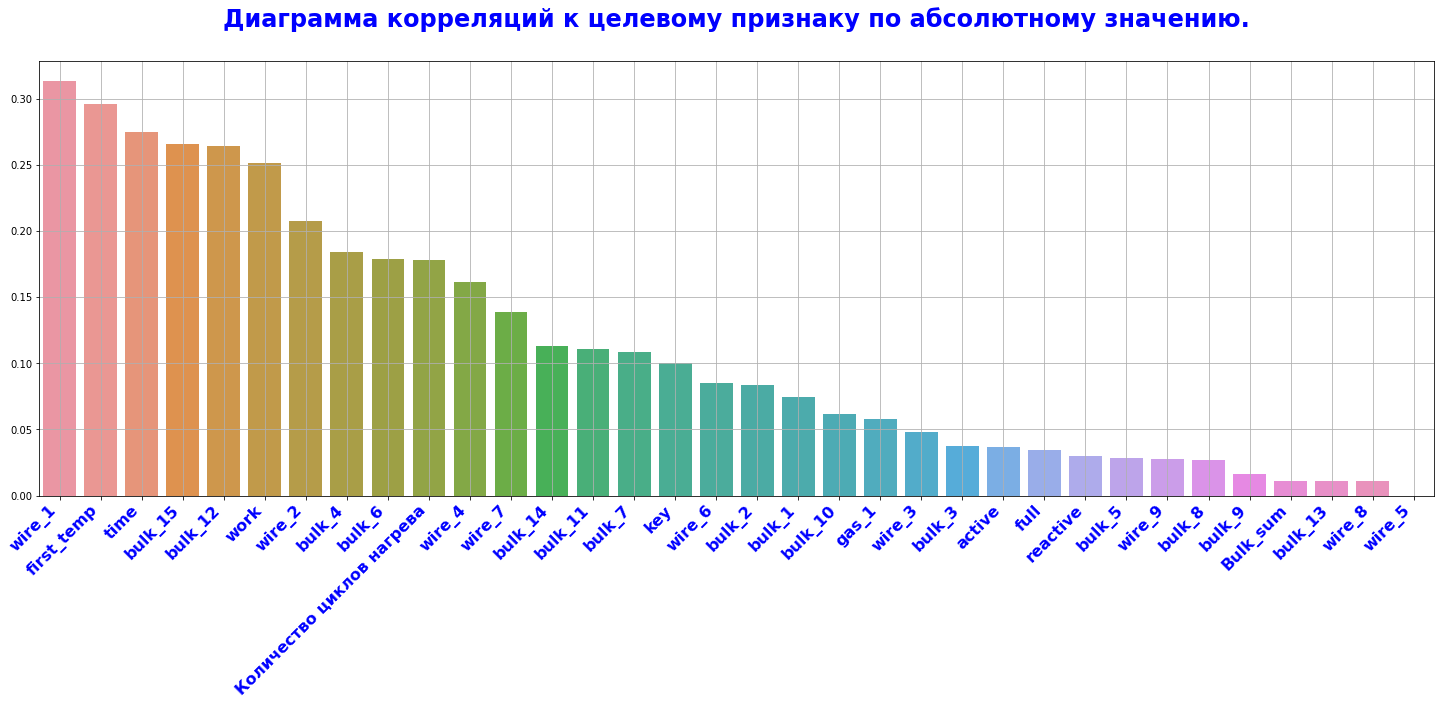

In [64]:
corr_data=pd.Series()
for i in total.columns:
    corr_data[i] = abs(total['last_temp'].corr(total[i]))
corr_data= corr_data.sort_values(ascending=False)[1:]
plt.figure(figsize=(25,8))
sns.barplot(x=corr_data.index, y=corr_data.values)
plt.title('Диаграмма корреляций к целевому признаку по абсолютному значению.\n ', fontsize=24, fontweight="bold", color='blue')
plt.grid()
plt.xticks(rotation=45, horizontalalignment='right', fontsize=16, fontweight="bold", color='blue')
plt.show()

In [65]:
display(total.corr().style.background_gradient(cmap='Blues', axis=0))

/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,key,Количество циклов нагрева,active,reactive,full,time,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,Bulk_sum,gas_1,first_temp,last_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,1.000000,-0.033113,0.014432,0.017710,0.015812,-0.029411,-0.018147,-0.073872,-0.005918,-0.004460,-0.027165,0.036016,0.006995,0.053044,0.015706,-0.039710,0.062342,0.038249,0.027850,-0.015587,-0.112009,-0.043544,0.926547,-0.044023,-0.018563,-0.100676,-0.016399,0.045757,-0.026973,0.049921,nan,-0.007800,0.037428,-0.035963,0.021888
Количество циклов нагрева,-0.033113,1.000000,0.033736,0.031772,0.033208,0.798105,0.711595,0.100881,0.093505,0.104818,-0.006772,0.075166,0.155568,0.153398,-0.009112,0.038264,0.007253,0.066884,0.304496,0.118338,0.334300,0.171730,0.124645,0.404664,-0.180018,0.178209,0.137196,0.080126,0.055277,0.114274,nan,0.053396,0.074106,0.043981,-0.025075
active,0.014432,0.033736,1.000000,0.965398,0.995383,0.050099,0.397623,0.023464,0.002835,0.025179,0.017805,0.004508,-0.000559,0.009094,-0.042108,-0.010930,-0.004827,0.020069,0.038973,-0.013911,0.022727,0.038254,0.032987,0.037697,-0.009746,0.036688,0.035142,-0.013084,0.019683,-0.005386,nan,0.010859,-0.003771,-0.005188,-0.006389
reactive,0.017710,0.031772,0.965398,1.000000,0.985957,0.043537,0.388383,0.019095,-0.000606,0.021112,0.019691,0.000057,-0.002086,0.008928,-0.041244,-0.017797,-0.008949,0.019739,0.043246,-0.013208,0.018760,0.037243,0.035568,0.039481,-0.004207,0.030107,0.042187,-0.013508,0.020970,-0.004918,nan,0.006428,0.003528,-0.012988,0.002791
full,0.015812,0.033208,0.995383,0.985957,1.000000,0.048046,0.397397,0.022063,0.001636,0.023968,0.018606,0.002941,-0.001279,0.009107,-0.042068,-0.013533,-0.006437,0.020031,0.040812,-0.013769,0.021434,0.038087,0.034227,0.038643,-0.007763,0.034525,0.038089,-0.013350,0.020271,-0.005244,nan,0.009363,-0.001095,-0.008087,-0.002909
time,-0.029411,0.798105,0.050099,0.043537,0.048046,1.000000,0.900609,0.104500,0.038061,0.090613,-0.031587,0.012912,0.164820,0.084886,-0.011505,0.012616,-0.013599,0.085325,0.464009,0.129833,0.460868,0.293806,0.179328,0.396945,-0.389817,0.275240,0.052713,0.055652,0.032965,0.054841,nan,0.041940,0.027648,0.017587,-0.012232
work,-0.018147,0.711595,0.397623,0.388383,0.397397,0.900609,1.000000,0.097357,0.037602,0.087644,-0.025159,0.018920,0.150765,0.079535,-0.023351,0.008164,-0.013371,0.076274,0.418870,0.133840,0.406460,0.271199,0.171044,0.354631,-0.351255,0.251992,0.057934,0.048492,0.035936,0.047720,nan,0.046858,0.020999,0.014706,-0.011737
bulk_1,-0.073872,0.100881,0.023464,0.019095,0.022063,0.104500,0.097357,1.000000,0.226133,-0.010562,0.041731,0.060678,-0.005293,0.238741,-0.005793,-0.019994,-0.023194,-0.037126,0.327590,-0.010457,0.208100,-0.000742,0.053466,0.239308,0.080946,-0.074785,0.015939,-0.011799,0.020246,0.147209,nan,0.149427,0.083967,-0.019770,0.011010
bulk_2,-0.005918,0.093505,0.002835,-0.000606,0.001636,0.038061,0.037602,0.226133,1.000000,-0.047474,0.041251,0.360208,-0.030278,0.679328,-0.001573,-0.005429,-0.018276,0.001806,-0.099924,-0.005693,-0.142219,-0.106788,0.009550,0.218612,0.142215,-0.083384,-0.170548,-0.039411,0.223085,0.699317,nan,0.558830,0.431721,-0.005368,-0.006965
bulk_3,-0.004460,0.104818,0.025179,0.021112,0.023968,0.090613,0.087644,-0.010562,-0.047474,1.000000,-0.294294,-0.007269,0.067300,-0.033941,0.020891,0.011159,-0.085691,-0.008599,0.018594,-0.013748,0.011122,-0.013362,0.074690,0.057504,-0.113218,-0.037734,0.038601,0.095714,0.005406,-0.041032,nan,0.006759,-0.019691,0.004626,0.004324


Вывод: Мы проверили все признаки на мультиколлениарность и на коллениарность к целевому признаку

## Подготовка данных

In [66]:
total.drop(['key', 'active', 'reactive', 'wire_8'], axis= 1 , inplace= True ) 
X = total.drop('last_temp', axis = 1)
y = total['last_temp']
RANDOM_STATE = 100225

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [67]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_train_scaler = pd.DataFrame(X_train_scaler, columns=X_train.columns)

Вывод:Мы удалили признаки с корелляцией больше 0.9 по модулю и разделили данные на выборки в соотношении 75/25. Также сделали масштабирование данных

## Обучение моделей машинного обучения

### Линейная регрессия

In [68]:
model_lr = LinearRegression()
mae_lr = round(abs(cross_val_score(model_lr, X=X_train_scaler, y=y_train, cv=5, scoring='neg_mean_absolute_error')).mean(), 2)
print('\u001b[38;5;19m','MAE LinearRegression = ', mae_lr, '\u001b[0m')

 MAE LinearRegression =  6.53 


### «Случайный лес»

In [69]:
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [20, 25, 30],
    'min_samples_split': [2, 3, 4],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]
}
model_rf = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
model_rf.fit(X_train, y_train)
print('\u001b[38;5;19m', model_rf.best_params_, '\u001b[0m')

 {'bootstrap': True, 'max_depth': 30, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 100225} 


In [70]:
mae_rf = round(abs(model_rf.best_score_), 2)
print('\u001b[38;5;19m','MAE RandomForestRegressor = ', mae_rf, '\u001b[0m') 

 MAE RandomForestRegressor =  6.38 


### Модель CatBoost

In [71]:
model = CatBoostRegressor() 
parameters = [{'learning_rate':[0.06, 0.065, 0.07, 0.075, 0.08], 'random_state':[RANDOM_STATE], 'verbose':[False]}]
model_cbr = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
model_cbr.fit(X_train, y_train)
print('\u001b[38;5;19m', model_cbr.best_params_, '\u001b[0m')

 {'learning_rate': 0.07, 'random_state': 100225, 'verbose': False} 


In [72]:
mae_cbr = round(abs(model_cbr.best_score_), 2)
print('\u001b[38;5;19m','MAE CatBoostRegressor = ', mae_cbr, '\u001b[0m')

 MAE CatBoostRegressor =  6.31 


Вывод: Проверили четыре модели: Линейная регрессия, RandomForestRegressor, CatBoostRegressor, LGBMRegressor. Лучший целевой показатель на тренировочных данных MAE=4.59 показала модель RandomForestRegressor.

## Выбор лучшей модели

In [73]:
model = DummyRegressor()
model.fit(X_train, y_train)
model.score(X_train, y_train)
pred=model.predict(X_test)
mae_clf = round(abs(mean_absolute_error(y_test, pred)), 2)
print('\u001b[38;5;19m','MAE DummyRegressor = ', mae_clf, '\u001b[0m')

 MAE DummyRegressor =  7.97 


In [74]:
data = {'MAE обучения, %':[mae_lr, mae_rf, mae_cbr, mae_clf]}
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'DummyRegressor']
data_final = pd.DataFrame(data=data, index=index)
pd.set_option('precision', 2)
display(data_final.sort_values(by='MAE обучения, %', ascending=True))

,"MAE обучения, %"
CatBoostRegressor,6.31
RandomForestRegressor,6.38
LinearRegression,6.53
DummyRegressor,7.97


In [75]:
model_cbr = CatBoostRegressor(learning_rate=0.06, random_state=RANDOM_STATE, verbose = False)
model_cbr.fit(X_train, y_train)
y_pred = model_cbr.predict(X_test)
mae_cbr = round(mean_absolute_error(y_test, y_pred), 2)
print('\u001b[38;5;19m','MAE CatBoostRegressor на тестовой выборке = ', mae_cbr, '\u001b[0m')

 MAE CatBoostRegressor на тестовой выборке =  6.51 


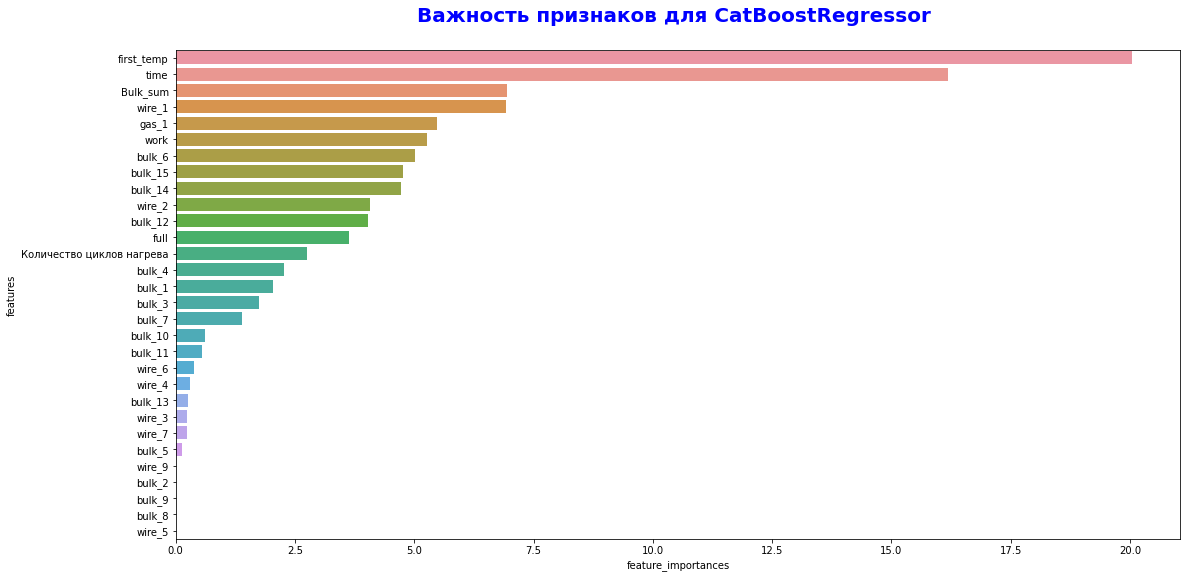

In [76]:
plot_data = {
    'features': X_test.columns,
    'feature_importances': model_cbr.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor \n', fontsize=20, fontweight="bold", color='blue')
plt.show()

Наиболее значимыми признаками для модели CatBoostRegressor:

first_temp

time

Bulk_sum

wire_1

gas_1 

work

bulk_6

bulk_15

bulk_14

wire_2


Вывод: Показатель MAE для итоговой модели CatBoostRegressor на тестовых данных равен 6.31. Получившийся результат проходит по условиям задачи MAE ≤ 6.8. Исследовали важность признаков для модели CatBoostRegressor. Замечаем, что основные значимые признаки для этой модели были новыми добавленными признаками.

## Общий вывод и рекомендации заказчику

Загрузили данные. Обработали пропуски и выбросы.

Изменили название столбцов согласно змеиному стилю.

Добавили признаки Количество циклов нагрева, time, min.

Добавили признаки full и work, высчитанные по формуле.

Добавили признак Bulk_sum общего объема добавленного сыпучего материала.

Удалили партии с пропусками в замерах температуры.

Целевым признаком по требованию заказчика является окончательная температура сплава.

Провели корреляционные анализ с визуализацией корреляций.

Удалили признаки active и reactive, чтобы устранить мультиколлинеарность.

Подготовили данные и разделили на 2 выборки train/test в соотношении 75/25 для дальнейшего обучения модели.

Проверили четыре модели: Линейная регрессия, «Случайный лес», CatBoostRegressor, LGBMRegressor.
    
Лучший целевой показатель на тренировочных данных MAE=6.31 показала модель CatBoostRegressor.

Показатель MAE для итоговой модели CatBoostRegressor на тестовых данных равен 6.51.

Получившийся результат проходит по условиям задачи MAE ≤ 6.8.

Исследовали важность признаков для модели CatBoostRegressor.

Замечаем, что основные значимые признаки для этой модели были новыми добавленными признаками.

Обученная модель CatBoostRegressor с подобранными гиперпараметрами рекомендована к использованию для прогнозирования температуры стали.